### Vehicle Detection Project

The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on labeled training images.
* Create a feature vector of HOG features, binned colors and histograms of colors.
* Train a classifier Linear SVM classifier on the feature vectors.
* Implement a sliding-window technique and use the trained SVM classifier to search for vehicles in images.
* Write a pipeline to processes a video stream and create a heat map of recurring detections to detect and follow vehicles.
* Estimate a bounding box for vehicles detected.
* Process test_video.mp4 and the project_video.mp4 with your pipeline tracking vehicles with the bounding boxes.


In [1]:
# load needed packages and set global parameters
import numpy as np 
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import h5py
import pickle
import sklearn
import time
from collections import deque
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

%matplotlib inline

output_dir = 'output_images'


C:\Users\sevan\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Functions for creating feature vectors for HOG, binned colors and histograms of colors

In [2]:
# convert color function from RGB to HSV, LUV, HLS, YUV and YCrCb
def convert_color(img, color_space):
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            print('Unknown color_space')
    else: 
        feature_image = np.copy(img)

    return feature_image

In [3]:
# function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # normalize the vector
    features = features.astype(np.float)/255.
    # Return the feature vector
    return features

In [4]:
# function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # normalize the vector
    hist_features = hist_features.astype(np.float)/(img.shape[0]*img.shape[1])
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# function to get HOG features by calling the scimage hog fucntion
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, tf_sqrt=False, feature_vec=True,):
    scale = 5
    if (tf_sqrt):
        scale = 1./3.
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  block_norm= 'L2-Hys', visualise=vis,
                                  transform_sqrt=tf_sqrt, feature_vector=feature_vec)

        return scale*features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys', visualise=vis,
                       transform_sqrt=tf_sqrt, feature_vector=feature_vec)

        return scale*features

In [6]:
# function to extract features from an image
def extract_features(img, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, 
                     hog_channel=0, hog_tsqrt=False,
                     spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)
   
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    # Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, tf_sqrt=hog_tsqrt, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, tf_sqrt=hog_tsqrt, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)

# funtion to extract freatures from files of images
def extract_feats_from_files(files, color_space='RGB', spatial_size=(32, 32),
                             hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, 
                             hog_channel=0, hog_tsqrt=False,
                             spatial_feat=True, hist_feat=True, hog_feat=True): 
    
    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of files
    for file in files:
        # Read in each one by one
        image = mpimg.imread(file) 
        if (image.dtype == np.float32):
            image *= 255
            image = image.astype(np.uint8)

        #print(np.amin(image.flatten()),np.amax(image.flatten()))
        # extract the features for each image.
        feats = extract_features(image, color_space, spatial_size,
                                hist_bins, orient, pix_per_cell, cell_per_block, 
                                hog_channel, hog_tsqrt,
                                spatial_feat, hist_feat, hog_feat)    

        # Append the new feature vector to the features list
        features.append(feats)
        
    # Return list of feature vectors
    return features


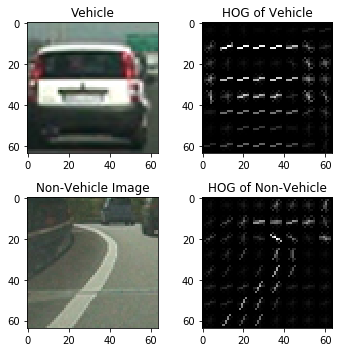

In [7]:
### plot of the HOG images for a vehicle and non-vehicle.

vehicle_file = 'vehicles/GTI_MiddleClose/image0142.png'
nonvehicle_file = 'non-vehicles/GTI/image1414.png'

v_img = mpimg.imread(vehicle_file)
if (v_img.dtype == np.float32):
    v_img *= 255
    v_img = v_img.astype(np.uint8)

n_img = mpimg.imread(nonvehicle_file)
if (n_img.dtype == np.float32):
    n_img *= 255
    n_img = n_img.astype(np.uint8)

color_space = 'YUV'
cv_img = convert_color(v_img,color_space)
cn_img = convert_color(n_img,color_space)

hc = 0
hog_cv_vec, hog_cv_img = get_hog_features(cv_img[:,:,hc], orient=9, pix_per_cell=8, 
                                          cell_per_block=2, vis=True)
hog_cn_vec, hog_cn_img = get_hog_features(cn_img[:,:,hc], orient=9, pix_per_cell=8, 
                                          cell_per_block=2, vis=True)

fig = plt.figure(num=1,figsize=(5,5))

fig.add_subplot(2,2,1)
plt.imshow(v_img)
plt.title('Vehicle')

fig.add_subplot(2,2,2)
plt.imshow(hog_cv_img,cmap='gray')
plt.title('HOG of Vehicle')

fig.add_subplot(2,2,3)
plt.imshow(n_img)
plt.title('Non-Vehicle Image')

fig.add_subplot(2,2,4)
plt.imshow(hog_cn_img,cmap='gray')
plt.title('HOG of Non-Vehicle')

plt.tight_layout()

fig.savefig(os.path.join(output_dir,"hog_examples.jpg"))


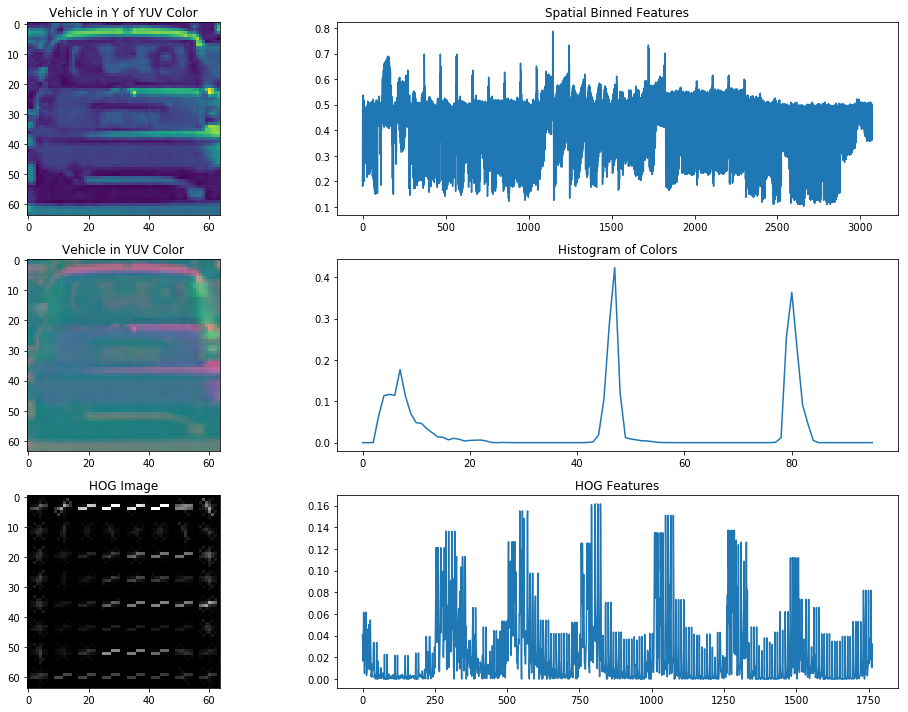

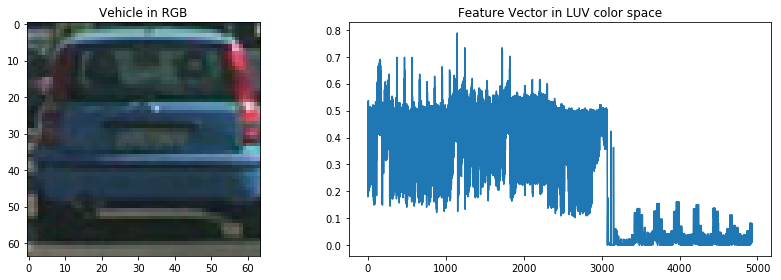

In [8]:
### plot an example of the feature vectors for an image. 
file_name = 'vehicles/GTI_MiddleClose/image0239.png'

img = mpimg.imread(file_name)
if (img.dtype == np.float32):
    img *= 255
    img = img.astype(np.uint8)

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
hog_tsqrt = False
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
    
color_img = convert_color(img,color_space)

spat_vec = bin_spatial(color_img,spatial_size)
color_vec = color_hist(color_img)
hc = hog_channel
hog_vec, hog_image = get_hog_features(color_img[:,:,hc], orient, pix_per_cell, cell_per_block, vis=True)

#print(img.shape)
fig = plt.figure(num=1,figsize=(15,10))
fig.add_subplot(3,2,1)
plt.imshow(color_img[:,:,0])
plt.title('Vehicle in Y of YUV Color')

fig.add_subplot(3,2,2)
plt.plot(spat_vec)
plt.title('Spatial Binned Features')

fig.add_subplot(3,2,3)
plt.imshow(color_img)
plt.title('Vehicle in YUV Color')

fig.add_subplot(3,2,4)
plt.plot(color_vec)
plt.title('Histogram of Colors')

#print(hog_image.shape)
fig.add_subplot(3,2,5)
plt.imshow(hog_image,cmap='gray')
plt.title('HOG Image')

fig.add_subplot(3,2,6)
plt.plot(hog_vec)
plt.title('HOG Features')

plt.tight_layout()

fig.savefig(os.path.join(output_dir,"features.jpg"))


# you need to nornalize the feature maps to == 1 or something.
feat_vec = extract_features(img, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block, 
                        hog_channel, hog_tsqrt,
                        spatial_feat, hist_feat, hog_feat) 

#print(img.shape)
fig = plt.figure(num=2,figsize=(12,4))
fig.add_subplot(1,2,1)
plt.imshow(img)
plt.title('Vehicle in RGB')

fig.add_subplot(1,2,2)
plt.plot(feat_vec)
plt.title('Feature Vector in LUV color space')

plt.tight_layout()

fig.savefig(os.path.join(output_dir,"feat_vec.jpg"))




In [9]:
### Parameters
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb   # best is LUV and YCrCb
svc_fit_file = os.path.join('svc_fits','svc_fit_'+color_space.lower()+'.p')
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
hog_tsqrt = False
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [10]:
# fit a svm classifier using the feature vectors.

# the training / test files.
#notcar_files = glob.glob('non-vehicles_smallset/*/*.jpeg')
#car_files = glob.glob('vehicles_smallset/*/*.jpeg')
notcar_files = glob.glob('non-vehicles/*/*.png')
car_files = glob.glob('vehicles/*/*.png')
print(len(car_files),len(notcar_files))

t=time.time()
car_features = extract_feats_from_files(car_files, color_space, spatial_size,
                                hist_bins, orient, pix_per_cell, cell_per_block, 
                                hog_channel, hog_tsqrt,
                                spatial_feat, hist_feat, hog_feat) 
notcar_features = extract_feats_from_files(notcar_files, color_space, spatial_size,
                                hist_bins, orient, pix_per_cell, cell_per_block, 
                                hog_channel, hog_tsqrt,
                                spatial_feat, hist_feat, hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()  #-- what are the best parmaeters
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# save the classifier to file.
fit_info = { 'svc': svc, 'X_scaler': X_scaler }
pickle.dump(fit_info, open(svc_fit_file,"wb"))

8792 8968
118.07 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
8.47 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9876
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
0.00263 Seconds to predict 10 labels with SVC


In [11]:
# load the classifier
fit_info = pickle.load(open(svc_fit_file,"rb"))
svc = fit_info["svc"]
X_scaler = fit_info["X_scaler"]


#### Functions for sliding windows, identifying vehicles and drawing boxes on images.

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space=color_space, orient=orient, 
              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
              spatial_size=spatial_size, hist_bins=hist_bins, hog_channel=hog_channel,
              spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):
    
    boxes = []
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch,color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))    
    
    ch0 = ctrans_tosearch[:,:,0]
    ch1 = ctrans_tosearch[:,:,1]
    ch2 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch0.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch0.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog0 = get_hog_features(ch0, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):            
            # the order of features should match the order found in the extract_features function
            features = []
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract the image patch
            xleft = xpos*pix_per_cell
            ytop  = ypos*pix_per_cell
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # the spatial features
            if (spatial_feat):
                spatial_features = bin_spatial(subimg, size=spatial_size)
                features.append(spatial_features)
            # the hist features
            if (hist_feat):
                hist_features = color_hist(subimg, nbins=hist_bins)
                features.append(hist_features)
            # Extract HOG for this patch
            if (hog_feat):
                hog_feat0 = hog0[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                if hog_channel == 'ALL':
                    hog_features = np.hstack((hog_feat0, hog_feat1, hog_feat2))
                elif hog_channel == 0:
                    hog_features = hog_feat0
                elif hog_channel == 1:
                    hog_features = hog_feat1
                elif hog_channel == 2:
                    hog_features = hog_feat2
                features.append(hog_features)
                
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate(features).reshape(1, -1))
                
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:  
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, boxes
    


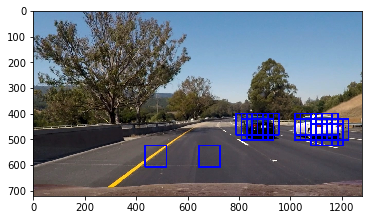

In [13]:
# process the test files
test_files = np.sort(glob.glob('test_images/*.jpg'))

for test_file in test_files:

    img = mpimg.imread(test_file)[:,:,:3]
    draw_image = np.copy(img)

    ystart = 400
    ystop = 680
    scale = 1.3
 
    window_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler,color_space,
                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    fig = plt.figure(num=1,figsize=(10,5))
    #fig.add_subplot(1,2,1)
    plt.imshow(window_img)
    #plt.tight_layout()

    plt_file = os.path.basename(test_file)
    plt_file = plt_file[:-4] + "wBoxes.jpg"
    fig.savefig(os.path.join(output_dir,plt_file))

#fig.add_subplot(2,1,2)

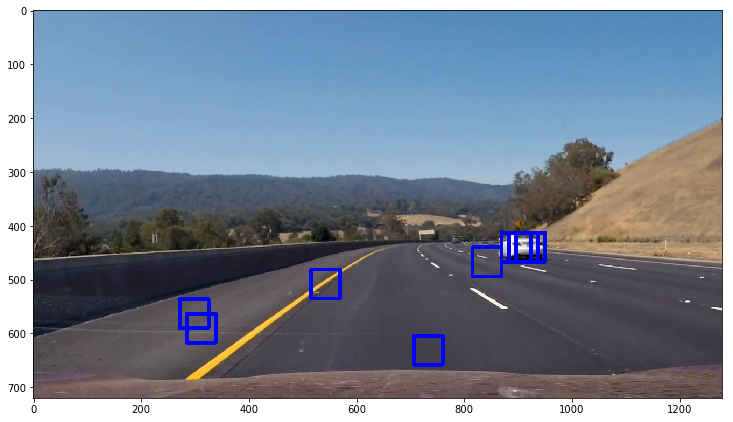

In [14]:
# check out other test files
test_files = np.sort(glob.glob('proj_video_images_2/*.jpg'))
test_file = test_files[96]

img = mpimg.imread(test_file)[:,:,:3]
draw_image = np.copy(img)

ystart = 400
ystop = 680
scale = 0.85
 
window_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler,color_space,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

fig = plt.figure(num=1,figsize=(10,5))
#fig.add_subplot(1,2,1)
plt.imshow(window_img)
#plt.tight_layout()

#fig.add_subplot(2,1,2)

#### Heat map functions that can be used to identy the object.

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [16]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

In [17]:
# remove tiny boxes
def rm_small_boxes(boxes, min_length=32):
 
    lg_boxes = list([])
    for (i,box) in enumerate(boxes):
        #print((box[1][0] - box[0][0]),(box[1][1] - box[0][1]))
        if ( ((box[1][0] - box[0][0]) > min_length)
            and ((box[1][1] - box[0][1]) > min_length) ):
            lg_boxes.append(box)
            
    return lg_boxes

In [18]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [19]:
def get_label_boxes(labels,min_cov=0):
    # Iterate through all detected cars
    boxes = list([])
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # 
        area = (bbox[1][0] - bbox[0][0] + 1)*(bbox[1][1]-bbox[0][1] + 1)
        cov = len(nonzero[0])/3./area
        if (cov > min_cov):
            boxes.append(bbox)
    
    # Return the image and boxes
    return boxes

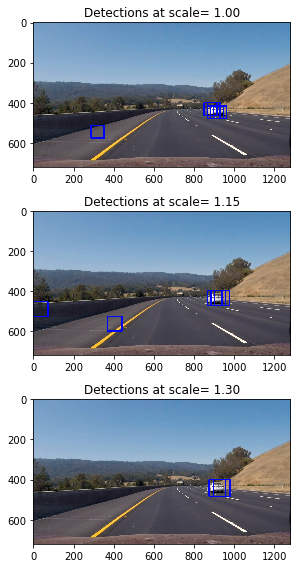

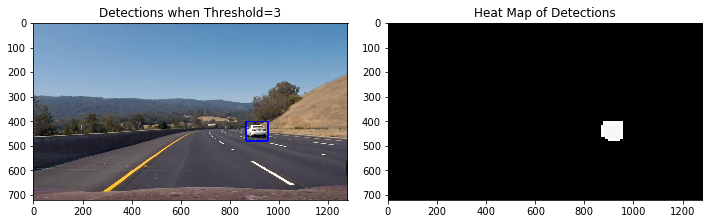

In [25]:
# run the window using 3-4 differnet window sizes
#test_files = np.sort(glob.glob('test_video_images/*.jpg'))
#test_file = test_files[28] #[24]
#test_files = np.sort(glob.glob('proj_video_images/*.jpg'))
#test_file = test_files[15]
#test_files = np.sort(glob.glob('proj_video_images_2/*.jpg'))
#test_file = test_files[45]
#test_files = np.sort(glob.glob('proj_video_images_3/*.jpg'))
#test_file = test_files[12]
#test_file = test_files[-1]
#test_files = np.sort(glob.glob('proj_video_images_4/*.jpg'))
#test_file = test_files[3]
test_files = np.sort(glob.glob('proj_video_images_5/*.jpg'))
test_file = test_files[50]

image = mpimg.imread(test_file)[:,:,:3]

heat = np.zeros(image.shape).astype(np.float32)

box_list = list([])

#scales = [0.7, 0.85, 1.0, 1.15, 1.3, 1.5]
#y_starts = [y_mid,y_mid,y_mid,y_mid,y_mid,y_mid]
#y_stops  = [int(0.7*y_max),int(0.8*y_max),int(0.9*y_max),y_max,y_max,y_max]
#y_starts = [400, 400, 400, 400, 400, 400]
#y_stops  = [500, 550, 600, 650, 650, 650]

scales = [1.0,1.15,1.3]
y_starts = [400, 400, 400]
y_stops  = [650, 650, 650]
thresh = 4.0

#scales = [1.15, 1.3] #, 1.7] #, 1.7]
#y_starts = [400, 400] #, 400]
#y_stops  = [650, 650] #, 650]
#thresh = 3.0

fig = plt.figure(num=1,figsize=(10,12))
n_plots = len(scales)+1

for i,scale in enumerate(scales):
    ystop = int(y_stops[i])
    ystart = int(y_starts[i])

    #print(i,ystart,ystop)
    boxes_img, boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, color_space,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    fig.add_subplot(n_plots,2,2*i+1)
    plt.title("Detections at scale={0:5.2f}".format(scale))
    plt.imshow(boxes_img)
    
    box_list += boxes
    
#fig.tight_layout()
#fig.savefig(os.path.join(output_dir,"detections.jpg"))

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,thresh)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
#print(labels)
label_boxes = get_label_boxes(labels)
label_boxes = rm_small_boxes(label_boxes)
draw_img = draw_boxes(np.copy(image), label_boxes)

#fig = plt.figure(num=2,figsize=(10,5))
plt.subplot(n_plots,2,2*n_plots-1)
plt.imshow(draw_img)
plt.title("Detections when Threshold={0:.2f}".format(thresh))
plt.subplot(n_plots,2,2*n_plots)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map of Detections')
fig.tight_layout()
#fig.savefig(os.path.join(output_dir,"heat_map.jpg"))
fig.savefig(os.path.join(output_dir,"detect_heat.jpg"))


In [26]:
# class of object boxes found over the past n image frames
class ObjectBoxes():
    def __init__(self):
        self.n_max = 16
        self.boxes = list([])

    def add_boxes(self,boxes):
        self.boxes.append(boxes)
        if (len(self.boxes) > self.n_max):
            self.boxes = self.boxes[1:]
        
    def get_boxes(self):
        all_boxes = list([])
        for boxes in self.boxes:
            all_boxes += boxes
        return all_boxes


In [27]:
def track_cars(image):
    global obj_boxes

    min_box_wl = 48
    ystart = 400
    ystop = 650 
 
    img1, boxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, color_space,
                             orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    img2, boxes2 = find_cars(image, ystart, ystop, 1.15, svc, X_scaler, color_space,
                             orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)   
    img3, boxes3 = find_cars(image, ystart, ystop, 1.3, svc, X_scaler, color_space,
                             orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes = boxes1 + boxes2 + boxes3
    
    # Create a heat map of the boxes
    heat = np.zeros(image.shape,dtype=np.uint8)
    heat = add_heat(heat,boxes)
    
    # Apply threshold to help remove false positives    
    min_heat = 4 #3  #4
    heat = apply_threshold(heat,min_heat)

    # Find the objects from the thresholded heatmap
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    label_boxes = get_label_boxes(labels)
    label_boxes = rm_small_boxes(label_boxes,min_box_wl)

    # Create the image of the detections for this frame
    frame_img = draw_boxes(image,label_boxes)
    
    # add the frame detections to the container of detections from the past N frames
    #print(label_boxes)
    obj_boxes.add_boxes(label_boxes)
    
    # Create a heat map of the boxes from the past n cells    
    all_boxes = obj_boxes.get_boxes()
    heat = add_heat(heat*0,all_boxes) 

    # Apply threshold to help remove false positives    
    min_heat = np.maximum(8,len(obj_boxes.boxes)-2) #1)
    heat = apply_threshold(heat,min_heat)
    
    # Find the objects from the thresholded heatmap
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    track_boxes = get_label_boxes(labels)
    track_boxes = rm_small_boxes(track_boxes,min_box_wl)
    #print(track_boxes)
    
    # Create the image of the tracked cars
    #print(len(label_boxes),len(track_boxes))
    track_img = draw_boxes(image,track_boxes)
    
    return track_img,frame_img

In [28]:
global obj_boxes
global i

i = 0
obj_boxes = ObjectBoxes()

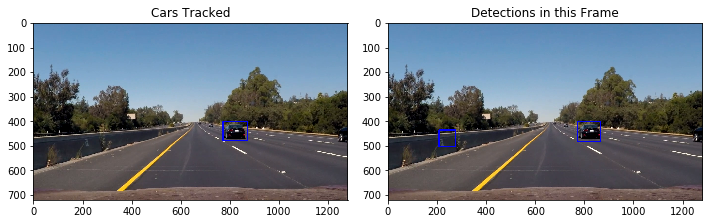

In [29]:
# test on a group of images.
#test_files = glob.glob('test_images/*.jpg')
#test_files = glob.glob('test_video_images/*.jpg')
test_files = glob.glob('proj_video_images_3/*.jpg')
#test_files = glob.glob('proj_video_images_2/*.jpg')
#test_files = glob.glob('proj_video_images/*.jpg')
test_files = np.sort(test_files)

i = 0
obj_boxes = ObjectBoxes()

track_img = [] 
draw_img = []
for (i,test_file) in enumerate(test_files[0:20]):
    image = mpimg.imread(test_file)[:,:,:3]
    track_img,frame_img = track_cars(image)

fig = plt.figure(num=1,figsize=(10,20))
plt.subplot(121)
plt.imshow(track_img)
plt.title('Cars Tracked')
plt.subplot(122)
plt.imshow(frame_img)
plt.title('Detections in this Frame')
fig.tight_layout()
fig.savefig(os.path.join(output_dir,"pipeline.jpg"))
    

## Test on Videos
Test the pipeline on the provided videos:

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
# process image function that calls the pipeline track_cars
def process_image(image):
    global i

    track_img,frame_img  = track_cars(image)
   
    #output_dir = "proj_video_images_5"
    #mpimg.imsave(os.path.join(output_dir,"test{0:03d}.jpg".format(i)),image)
    i += 1
    
    return track_img

In [32]:
i = 0
obj_boxes = ObjectBoxes()

In [33]:
test_output = 'output_videos/test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_video.mp4")

test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|█████████▋| 38/39 [01:36<00:02,  2.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 1min 41s, sys: 840 ms, total: 1min 42s
Wall time: 1min 37s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [35]:
i = 0
obj_boxes = ObjectBoxes()

In [36]:
project_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(48,51)
#clip1 = VideoFileClip("project_video.mp4").subclip(36,39)
#clip1 = VideoFileClip("project_video.mp4").subclip(25,30)
#clip1 = VideoFileClip("project_video.mp4").subclip(20,24)
#clip1 = VideoFileClip("project_video.mp4").subclip(14,17)
#clip1 = VideoFileClip("project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("project_video.mp4")

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [52:16<00:02,  2.48s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 54min 49s, sys: 24.7 s, total: 55min 13s
Wall time: 52min 17s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))